<a href="https://colab.research.google.com/github/briannabinder/AME508_finalproject/blob/main/112723AME508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import requests
import base64
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
from scipy.io import wavfile
from torchsummary import summary
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsampler import ImbalancedDatasetSampler


Drive mount from my personal driver

In [21]:
#from google.colab import drive
#drive.mount('/content/drive')

Wav to spectrogram

nperseg: 448 noverlap: 181
File: 4666.wav, Spectrogram shape: (224, 224)


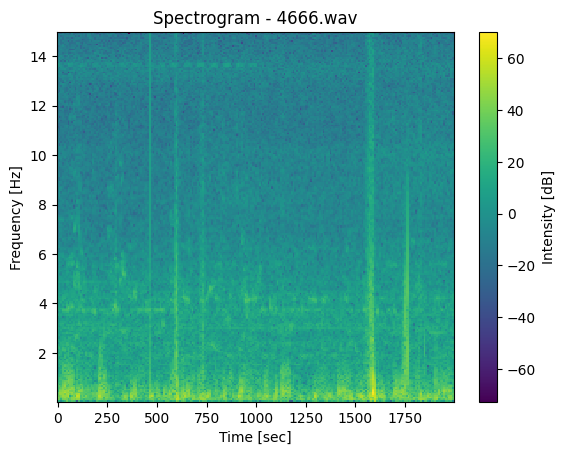

(7809, 1, 224, 224)


In [5]:
# Specify the folder path
#folder_path = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Train_Datasets'
folder_path = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/train2'
#folder_path = '/Users/briannabinder/Desktop/508/AME508_finalproject/train2'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# List to store all log_spectrograms
all_spectrograms = []

def calculate_noverlap():
  steth_sample_rate = 4000
  duration = 15
  total_samples = steth_sample_rate * duration
  num_freq_bins = 224
  num_time_steps = 224

  nperseg = 2 * num_freq_bins  # (Nyquist limit)

  # num_time_steps = (total samples - noverlap) / (nperseg - noverlap)
  # t = s - o / p - o
  # tp - to = s - o
  # o = (tp - s) / (t - 1)

  noverlap = round((num_time_steps * nperseg - total_samples) / (num_time_steps - 1))
  return int(nperseg), int(noverlap)

nperseg, noverlap = calculate_noverlap()
print("nperseg:", nperseg, "noverlap:", noverlap)

def plot_spectrogram(nperseg, noverlap):
    # Iterate through each .wav file in the folder
    for wav_file in file_list:
        # Construct the full path to the .wav file
        wav_file_path = os.path.join(folder_path, wav_file)

        # Read the WAV file
        sample_rate, samples = wavfile.read(wav_file_path)

        # Compute the spectrogram
        frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

        # Apply logarithmic transformation
        log_spectrogram = resize(10 * np.log10(spectrogram+1e-10),(224,224))

        # Store the log_spectrogram in the list
        all_spectrograms.append(log_spectrogram)

    # Print the shape of the first spectrogram
    print(f"File: {file_list[0]}, Spectrogram shape: {all_spectrograms[0].shape}")

    # Ensure X has shape (225, 224) and Y has shape (224, 225)
    X, Y = np.meshgrid(times[:225], frequencies[:224], indexing='ij')

    #print(f"Original Spectrogram shape: {spectrogram.shape}")
    #print(f"Resized Spectrogram shape: {all_spectrograms[0].shape}")
    #print(f"X shape: {X.shape}")
    #print(f"Y shape: {Y.shape}")
    

    # Plot the first spectrogram
    plt.pcolormesh(Y, X, all_spectrograms[0], shading='auto')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Spectrogram - {file_list[0]}')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Plot the spectrogram with calculated nperseg and noverlap
plot_spectrogram(nperseg, noverlap)

all_resized_spectrograms = np.reshape(np.array(all_spectrograms), newshape=(7809,1,224,224))

print(all_resized_spectrograms.shape)

Test datasets .wav

In [ ]:
''' REDOOOOOOOOO



# Specify the folder path
#folder_path1 = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Test_Datasets'
folder_path1 ='/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/test'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if f.endswith('.wav')]

# List to store all log_spectrograms
all_spectrograms1 = []

# Iterate through each .wav file in the folder
for wav_file in file_list:
    # Construct the full path to the .wav file
    wav_file_path = os.path.join(folder_path1, wav_file)

    # Read the content of the .wav file
    sample_rate, samples = wavfile.read(wav_file_path)

    # Compute the spectrogram
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    # Apply logarithmic transformation
    log_spectrogram1 = 10 * np.log10(spectrogram)

    # Store the log_spectrogram in the list
    all_spectrograms1.append(log_spectrogram1)

# Specify the target size
target_size = (224, 224)

# List to store all resized log_spectrograms
all_resized_spectrograms1 = []

# Iterate through each log_spectrogram
for log_spectrogram1 in all_spectrograms1:
    # Resize the log_spectrogram to the target size
    resized_log_spectrogram1 = resize(log_spectrogram1, target_size, anti_aliasing=True)

    # Store the resized log_spectrogram in the list
    all_resized_spectrograms1.append(resized_log_spectrogram1)


all_resized_spectrograms1 = np.reshape(np.array(all_resized_spectrograms1), newshape=(1185,1,224,224))


print(all_resized_spectrograms1.shape)
'''


Train datasets Label Reader Mulit Hot Encoder


In [24]:
'''
# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices = np.array([item['vector'] for item in all_multi_hot_matrices])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices)}")
'''


Total count of files: 0


In [6]:
# Get a list of all .npy files in the folder
npy_file_list = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

# List to store file names and arrays
all_multi_hot_matrices = []

# Iterate through each .npy file
for npy_file in npy_file_list:
    # Construct the full path to the .npy file
    npy_file_path = os.path.join(folder_path, npy_file)

    # Load the .npy file
    multi_hot_array = np.load(npy_file_path)

    # Remove the file extension from the file name
    file_name = os.path.splitext(npy_file)[0]

    # Append the file name and array to the list
    all_multi_hot_matrices.append({
        'file_name': file_name,
        'array': multi_hot_array.tolist()  # Convert to list for better readability
    })

# Create a NumPy array to store all the arrays
multi_hot_matrices = np.array([item['array'] for item in all_multi_hot_matrices])

'''
# Print or use the values as needed
for item in all_multi_hot_matrices:
    file_name = item['file_name']
    array = item['array']
    print(f"File: {file_name}, Array: {array}")
'''

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices)}")


Total count of files: 7809


Test_datasets Label Reader Mulit Hot Encoder

In [ ]:
''' REDOOOOOOOOO

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if os.path.isfile(os.path.join(folder_path1, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi', 'Crackles']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices1 = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path1, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector1 = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector1.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices1.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector1
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices1 = np.array([item['vector'] for item in all_multi_hot_matrices1])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices1:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices1)}")
'''

CustomDataset

In [7]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        """
        Initialize the CustomDataset with paired samples.

        Args:
            samples (list of tuples): A list of (x, y) pairs representing the dataset samples.
        """
        self.samples = torch.Tensor(samples).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the sample pairs corresponding to the given list of indices.

        Args:
            indices (list): A list of indices to retrieve samples for.

        Returns:
            list: A list of (x, y) pairs corresponding to the specified indices.
        """
        selected_sample = self.samples[idx]
        selected_label = self.labels[idx]
        return selected_sample , selected_label
    
    def get_labels(self):
        """
        Returns the labels of the dataset.
        """
        return self.labels

In [8]:
batch_size = 32
train_dataset = CustomDataset(all_resized_spectrograms,multi_hot_matrices)

# Define a sampler for the training dataset
#train_sampler = ImbalancedDatasetSampler(train_dataset)

#test_dataset = CustomDataset(all_resized_spectrograms1,multi_hot_matrices1)

trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size , shuffle=True)#, sampler=train_sampler)

#testloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1185)

 VGG16 CNN as feature extractors



In [9]:
class VGG16(nn.Module):
    def __init__(self, verbose=False):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc3 = nn.Linear(4096, 3)

        self.verbose = verbose

    def forward(self, x):
        if self.verbose:
            print(f"Input shape: {x.size()}")

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        if self.verbose:
            print(f"After Layer 1: {x.size()}")

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        if self.verbose:
            print(f"After Layer 2: {x.size()}")

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        if self.verbose:
            print(f"After Layer 3: {x.size()}")

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        if self.verbose:
            print(f"After Layer 4: {x.size()}")

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        if self.verbose:
            print(f"After Layer 5 {x.size()}")

        x = torch.flatten(x,1)
        #x = torch.unsqueeze(1,x)
        if self.verbose:
            print(f"Flattened: {x.size()}")

        x = F.relu(self.fc1(x))
        if self.verbose:
            print(f"After first Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = F.relu(self.fc2(x))
        if self.verbose:
            print(f"After Secound Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = self.fc3(x)
        #x = torch.sigmoid(x)  # Apply sigmoid activation
        
        
        if self.verbose:
            print(f"Output shape: {x.size()}")

        return x

Check for GPU

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


Testing VGG16 CNN shape size

In [15]:
print("Intermediate shapes for VGG16")
model = VGG16(verbose=True)
output = model(torch.ones(size=(1,1,224,224)))
# More infor on VGG16 (https://builtin.com/machine-learning/vgg16)

Intermediate shapes for VGG16
Input shape: torch.Size([1, 1, 224, 224])
After Layer 1: torch.Size([1, 64, 112, 112])
After Layer 2: torch.Size([1, 128, 56, 56])
After Layer 3: torch.Size([1, 256, 28, 28])
After Layer 4: torch.Size([1, 512, 14, 14])
After Layer 5 torch.Size([1, 512, 7, 7])
Flattened: torch.Size([1, 25088])
After first Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
After Secound Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
Output shape: torch.Size([1, 3])


In [ ]:
#torch.cuda.empty_cache()

#torch.cuda.memory_summary(device=None, abbreviated=False)

Training VGG16 CNN with BCE Loss

In [13]:
def check_nonzero(y_true, y_pred):
    for sample in y_true:
        if any(value != 0 for value in sample):
            return True
    for sample in y_pred:
        if any(value != 0 for value in sample):
            return True
    return False
        

def train_loop_bce(model, criterion, optimizer, n_epoch, n_batches, print_every):
    loss_hist = np.zeros(n_epoch * n_batches)
    precision_hist = np.zeros((n_epoch, 3))
    recall_hist = np.zeros((n_epoch, 3))
    f1_hist = np.zeros((n_epoch, 3))
    
    avg_precision_epoch = np.zeros((n_epoch, 3))
    avg_recall_epoch = np.zeros((n_epoch, 3))
    avg_f1_epoch = np.zeros((n_epoch, 3))

    it = 0
    for epoch in range(n_epoch):
        all_predictions = []
        all_labels = []
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # Convert logits to binary predictions
            predictions = (outputs > 0.5).float()

            # Aggregate predictions and labels for the entire epoch
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loss_hist[it] = loss.item()

            it += 1

            if (i + 1) % print_every == 0:
                print('minibatch = {}/{}, loss = {}'.format(i + 1, n_batches, loss.item()))

        # Calculate precision, recall, and F1 for the entire epoch
        if (check_nonzero(all_labels, all_predictions)):
            precision = precision_score(all_labels, all_predictions, average=None)
            recall = recall_score(all_labels, all_predictions, average=None)
            f1 = f1_score(all_labels, all_predictions, average=None)
        else:
            precision = 0
            recall = 0
            f1 = 0

        precision_hist[epoch] = precision


        recall_hist[epoch] = recall
        f1_hist[epoch] = f1

        # Calculate and print average precision, recall, and F1 for the epoch
        avg_precision_epoch[epoch] = np.mean(precision)
        avg_recall_epoch[epoch] = np.mean(recall)
        avg_f1_epoch[epoch] = np.mean(f1)

        print('epoch = {}/{}, Avg Precision = {}, Avg Recall = {}, Avg F1 score = {}'.format(epoch + 1, n_epoch,
                                                                                              avg_precision_epoch[epoch],
                                                                                              avg_recall_epoch[epoch],
                                                                                              avg_f1_epoch[epoch]))

    print("Finished Training")
    return loss_hist, precision_hist, recall_hist, f1_hist, avg_precision_epoch, avg_recall_epoch, avg_f1_epoch



Running train loop with BCE loss

What could work:
- Find number of each class present
- convert into one hot encoded into multi hot encoded and make BCE work
- Then check precision, recall stuff
- Make everythig including testing works with one hot encoded
- make sure test dataset also has same class imabalance
- if everything works and there is time, convert to multi-hot encoded


In [14]:
'''
# Calculate class frequencies
class_counts = np.sum(multi_hot_matrices, axis=0)

# Add a small constant to avoid division by zero
epsilon = 1e-10
class_weights = 1.0 / (class_counts + epsilon)

# Normalize class weights
class_weights /= np.sum(class_weights)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.Tensor(class_weights)

'''
model = VGG16()#.to(device)
criterion = nn.BCEWithLogitsLoss()#pos_weight=class_weights_tensor)
learning_rate = 0.01 
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-8)
n_epoch   = 10
n_batches = len(trainloader)
print_every = 1

loss_bce, precision_bce, recall_bce, f1_bce = train_loop_bce(model,criterion,optimizer,n_epoch,n_batches,print_every)

minibatch = 1/245, loss = 0.6936653256416321
minibatch = 2/245, loss = 2599624376320.0
minibatch = 3/245, loss = 1626.08740234375
minibatch = 4/245, loss = 670.4878540039062
minibatch = 5/245, loss = 19360.939453125
minibatch = 6/245, loss = 375836.21875
minibatch = 7/245, loss = 89393.7890625
minibatch = 8/245, loss = 24.405420303344727
minibatch = 9/245, loss = 1.2128013372421265
minibatch = 10/245, loss = 3.263258695602417
minibatch = 11/245, loss = 11153.9775390625
minibatch = 12/245, loss = 840.2343139648438
minibatch = 13/245, loss = 1.4906378984451294
minibatch = 14/245, loss = 13.91583251953125
minibatch = 15/245, loss = 5.075550556182861
minibatch = 16/245, loss = 3.203997850418091
minibatch = 17/245, loss = 5.13043212890625
minibatch = 18/245, loss = 7.933103084564209
minibatch = 19/245, loss = 9.130760192871094
minibatch = 20/245, loss = 3.8642690181732178
minibatch = 21/245, loss = 10.839908599853516
minibatch = 22/245, loss = 165.08668518066406
minibatch = 23/245, loss = 3

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.37686702609062195
minibatch = 2/245, loss = 0.4115857779979706
minibatch = 3/245, loss = 0.4353795349597931
minibatch = 4/245, loss = 0.38951241970062256
minibatch = 5/245, loss = 0.4160386323928833
minibatch = 6/245, loss = 0.4467178285121918
minibatch = 7/245, loss = 0.3109351694583893
minibatch = 8/245, loss = 0.3049459457397461
minibatch = 9/245, loss = 0.2699280083179474
minibatch = 10/245, loss = 0.4393061101436615
minibatch = 11/245, loss = 0.35158586502075195
minibatch = 12/245, loss = 0.40663671493530273
minibatch = 13/245, loss = 0.3020893931388855
minibatch = 14/245, loss = 0.29139360785484314
minibatch = 15/245, loss = 0.30624738335609436
minibatch = 16/245, loss = 0.46396753191947937
minibatch = 17/245, loss = 0.37037762999534607
minibatch = 18/245, loss = 0.36250734329223633
minibatch = 19/245, loss = 0.42816683650016785
minibatch = 20/245, loss = 0.4320298135280609
minibatch = 21/245, loss = 0.47660598158836365
minibatch = 22/245, loss = 0.423

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.41837501525878906
minibatch = 2/245, loss = 0.3469989597797394
minibatch = 3/245, loss = 0.3840707242488861
minibatch = 4/245, loss = 0.3313051164150238
minibatch = 5/245, loss = 0.4735715091228485
minibatch = 6/245, loss = 0.2998400032520294
minibatch = 7/245, loss = 0.41484594345092773
minibatch = 8/245, loss = 0.3521900475025177
minibatch = 9/245, loss = 0.36417877674102783
minibatch = 10/245, loss = 0.43368127942085266
minibatch = 11/245, loss = 0.3990851640701294
minibatch = 12/245, loss = 0.3798730671405792
minibatch = 13/245, loss = 0.28296124935150146
minibatch = 14/245, loss = 0.33762872219085693
minibatch = 15/245, loss = 0.43697142601013184
minibatch = 16/245, loss = 0.35478660464286804
minibatch = 17/245, loss = 0.45059147477149963
minibatch = 18/245, loss = 0.35168376564979553
minibatch = 19/245, loss = 0.3692833185195923
minibatch = 20/245, loss = 0.3809526860713959
minibatch = 21/245, loss = 0.29616424441337585
minibatch = 22/245, loss = 0.402

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.38969966769218445
minibatch = 2/245, loss = 0.31359386444091797
minibatch = 3/245, loss = 0.4015907049179077
minibatch = 4/245, loss = 0.39304447174072266
minibatch = 5/245, loss = 0.2768886983394623
minibatch = 6/245, loss = 0.32610177993774414
minibatch = 7/245, loss = 0.38473108410835266
minibatch = 8/245, loss = 0.38315698504447937
minibatch = 9/245, loss = 0.4127896726131439
minibatch = 10/245, loss = 0.35174763202667236
minibatch = 11/245, loss = 0.4257175028324127
minibatch = 12/245, loss = 0.3843328654766083
minibatch = 13/245, loss = 0.34212157130241394
minibatch = 14/245, loss = 0.4346027076244354
minibatch = 15/245, loss = 0.4413258731365204
minibatch = 16/245, loss = 0.34543612599372864
minibatch = 17/245, loss = 0.33757516741752625
minibatch = 18/245, loss = 0.3932516872882843
minibatch = 19/245, loss = 0.3586740493774414
minibatch = 20/245, loss = 0.34826621413230896
minibatch = 21/245, loss = 0.350207656621933
minibatch = 22/245, loss = 0.2822

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.34946703910827637
minibatch = 2/245, loss = 0.40567710995674133
minibatch = 3/245, loss = 0.413986474275589
minibatch = 4/245, loss = 0.32563522458076477
minibatch = 5/245, loss = 0.3508194386959076
minibatch = 6/245, loss = 0.4684561491012573
minibatch = 7/245, loss = 0.30503860116004944
minibatch = 8/245, loss = 0.3879297077655792
minibatch = 9/245, loss = 0.4265718162059784
minibatch = 10/245, loss = 0.30336233973503113
minibatch = 11/245, loss = 0.4407374858856201
minibatch = 12/245, loss = 0.3346095383167267
minibatch = 13/245, loss = 0.3213198482990265
minibatch = 14/245, loss = 0.43494394421577454
minibatch = 15/245, loss = 0.31139305233955383
minibatch = 16/245, loss = 0.34500381350517273
minibatch = 17/245, loss = 0.3972318470478058
minibatch = 18/245, loss = 0.4303266704082489
minibatch = 19/245, loss = 0.4044484794139862
minibatch = 20/245, loss = 0.39026546478271484
minibatch = 21/245, loss = 0.33889177441596985
minibatch = 22/245, loss = 0.42144

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.37619638442993164
minibatch = 2/245, loss = 0.3862896263599396
minibatch = 3/245, loss = 0.2716834247112274
minibatch = 4/245, loss = 0.3652697503566742
minibatch = 5/245, loss = 0.45843827724456787
minibatch = 6/245, loss = 0.3558010756969452
minibatch = 7/245, loss = 0.36411044001579285
minibatch = 8/245, loss = 0.3800155222415924
minibatch = 9/245, loss = 0.43937087059020996
minibatch = 10/245, loss = 0.3509327471256256
minibatch = 11/245, loss = 0.43739965558052063
minibatch = 12/245, loss = 0.309163898229599
minibatch = 13/245, loss = 0.43697425723075867
minibatch = 14/245, loss = 0.4101078510284424
minibatch = 15/245, loss = 0.34752264618873596
minibatch = 16/245, loss = 0.316142201423645
minibatch = 17/245, loss = 0.3808288872241974
minibatch = 18/245, loss = 0.3336181342601776
minibatch = 19/245, loss = 0.2974478602409363
minibatch = 20/245, loss = 0.39153698086738586
minibatch = 21/245, loss = 0.4243125915527344
minibatch = 22/245, loss = 0.30365124

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.32119467854499817
minibatch = 2/245, loss = 0.3841594457626343
minibatch = 3/245, loss = 0.3439825773239136
minibatch = 4/245, loss = 0.46933016180992126
minibatch = 5/245, loss = 0.32644400000572205
minibatch = 6/245, loss = 0.3803771436214447
minibatch = 7/245, loss = 0.29328736662864685
minibatch = 8/245, loss = 0.33949682116508484
minibatch = 9/245, loss = 0.41394293308258057
minibatch = 10/245, loss = 0.29981857538223267
minibatch = 11/245, loss = 0.38226309418678284
minibatch = 12/245, loss = 0.25434577465057373
minibatch = 13/245, loss = 0.4846589267253876
minibatch = 14/245, loss = 0.32452839612960815
minibatch = 15/245, loss = 0.4450747072696686
minibatch = 16/245, loss = 0.29223117232322693
minibatch = 17/245, loss = 0.3552287817001343
minibatch = 18/245, loss = 0.436131089925766
minibatch = 19/245, loss = 0.3392799198627472
minibatch = 20/245, loss = 0.3115331530570984
minibatch = 21/245, loss = 0.3366532325744629
minibatch = 22/245, loss = 0.4375

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.3430308401584625
minibatch = 2/245, loss = 0.4200804531574249
minibatch = 3/245, loss = 0.28965869545936584
minibatch = 4/245, loss = 0.3790431022644043
minibatch = 5/245, loss = 0.41325196623802185
minibatch = 6/245, loss = 0.4310116767883301
minibatch = 7/245, loss = 0.3864319324493408
minibatch = 8/245, loss = 0.44154873490333557
minibatch = 9/245, loss = 0.4088720977306366
minibatch = 10/245, loss = 0.36397793889045715
minibatch = 11/245, loss = 0.3397335112094879
minibatch = 12/245, loss = 0.44206079840660095
minibatch = 13/245, loss = 0.3736538589000702
minibatch = 14/245, loss = 0.4535343647003174
minibatch = 15/245, loss = 0.44063425064086914
minibatch = 16/245, loss = 0.4328770935535431
minibatch = 17/245, loss = 0.30391693115234375
minibatch = 18/245, loss = 0.2860662639141083
minibatch = 19/245, loss = 0.3748045265674591
minibatch = 20/245, loss = 0.27853554487228394
minibatch = 21/245, loss = 0.4027489721775055
minibatch = 22/245, loss = 0.379432

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.4266141951084137
minibatch = 2/245, loss = 0.45526567101478577
minibatch = 3/245, loss = 0.3443361520767212
minibatch = 4/245, loss = 0.33063197135925293
minibatch = 5/245, loss = 0.3692859709262848
minibatch = 6/245, loss = 0.41851887106895447
minibatch = 7/245, loss = 0.40526625514030457
minibatch = 8/245, loss = 0.4423941373825073
minibatch = 9/245, loss = 0.28765931725502014
minibatch = 10/245, loss = 0.37744733691215515
minibatch = 11/245, loss = 0.4017954170703888
minibatch = 12/245, loss = 0.33422669768333435
minibatch = 13/245, loss = 0.3955061435699463
minibatch = 14/245, loss = 0.3539522588253021
minibatch = 15/245, loss = 0.275894433259964
minibatch = 16/245, loss = 0.3842121362686157
minibatch = 17/245, loss = 0.3506506383419037
minibatch = 18/245, loss = 0.3216575086116791
minibatch = 19/245, loss = 0.44175222516059875
minibatch = 20/245, loss = 0.3368189036846161
minibatch = 21/245, loss = 0.40280187129974365
minibatch = 22/245, loss = 0.426132

KeyboardInterrupt: 

Plotting BCE training losses

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training loss
axs[0].plot(loss_bce, label="Train Datasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()

# Plot accuracy
axs[1].plot(precision_bce, label="Precision", color='blue')
axs[1].set_ylabel('Metric')

# Add two more curves for accuracy
axs[1].plot(recall_bce, label="Recall", color='green')
axs[1].plot(f1_bce, label="F1 Score", color='red')

axs[1].set_xlabel('Iterations')
axs[1].legend()

plt.show()

Class for sensitivity-specificity loss (SS loss)

In [ ]:
class SensitivitySpecificityLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(SensitivitySpecificityLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, outputs, targets):
        # Convert multi-hot encoded targets to binary
        targets_binary = (targets > 0.5).float()

        # Calculate true positive, true negative, false positive, and false negative
        true_positive = torch.sum((outputs > 0.5) * (targets_binary == 1)).float()
        true_negative = torch.sum((outputs <= 0.5) * (targets_binary == 0)).float()
        false_positive = torch.sum((outputs > 0.5) * (targets_binary == 0)).float()
        false_negative = torch.sum((outputs <= 0.5) * (targets_binary == 1)).float()

        # Calculate sensitivity and specificity
        sensitivity = true_positive / (true_positive + false_negative + 1e-10)
        specificity = true_negative / (true_negative + false_positive + 1e-10)

        # Use sensitivity and specificity in the loss function
        loss = self.alpha * (1 - sensitivity) + self.beta * (1 - specificity)

        return torch.tensor(loss, requires_grad=True)


Train loop with SS loss

In [ ]:
def train_loop_ss(model,criterion,optimizer,n_epoch,n_batches,print_every):
    loss_hist = np.zeros(n_epoch*n_batches)
    acc_hist  = np.zeros(n_epoch*n_batches)

    it = 0
    for epoch in range(n_epoch):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            loss_hist[it] = loss.item()
            _, predicted = torch.max(outputs.data, 1)
            acc_hist[it] = 100.0 * torch.sum(torch.from_numpy(predicted.cpu().numpy()) == torch.argmax(torch.from_numpy(labels.cpu().numpy()), axis=1)).item() / labels.size(0)



            if (i + 1) % print_every == 0:
                print('epoch = {}/{}, minibatch = {}/{}, loss = {}, accuracy = {}'.format(epoch + 1, n_epoch, i + 1,
                                                                                        n_batches, loss.item(),
                                                                                        acc_hist[it]))
        it += 1

    print('Finished Training')
    return loss_hist, acc_hist

Running train loop with SS loss

In [ ]:

model = VGG16().to(device)
criterion = SensitivitySpecificityLoss(alpha=0.5, beta=0.5)  # Adjust alpha and beta as needed
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
n_epoch = 1
n_batches = len(trainloader)
print_every = 10

loss_ss, acc_ss = train_loop_ss(model,criterion,optimizer,n_epoch,n_batches,print_every)

Plot SS loss metric

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(loss_ss, label = "TrainDatasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()


axs[1].plot(acc_ss, label = "TrainDatasets")
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_xlabel('Iterations')
axs[1].legend()

Save the variable of training model for reusing purpose

In [ ]:
# Save all relevant information at the end of training
#Store_variable = {
 #   'model_state_dict': model.state_dict(),
 #   'optimizer_state_dict': optimizer.state_dict(),
 #   'loss_history': loss_hist,
 #   'accuracy_history': acc_hist,
 #   'train_dataset' : train_dataset,
 #   'test_dataset' : test_dataset,
 #   'trainloader' : trainloader,
 #   'testloader' : testloader,
#}

# Save the model to a file
torch.save({'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_hist,
    'accuracy_history': acc_hist,
    'train_dataset' : train_dataset,
    'test_dataset' : test_dataset,
    'trainloader' : trainloader,
    'testloader' : testloader}, )
# Create a download link link from Jupyter Notebook
from IPython.display import FileLink
FileLink(Store_variable)

# Load the model from the file
model, optimizer, loss_history, accuracy_history, train_dataset,test_dataset,trainloader,testloader = torch.load(Store_variable).values()

Testing

In [ ]:
# Find accuracy over tasting set

def find_vacc(net,loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += np.sum(predicted.cpu().numpy() == np.argmax(labels.numpy(), axis=1))
    vacc = 100.0 * correct / total
    return vacc

test_acc = find_vacc(model, testloader)

print(f'Accuracy of the network trained on the test images: {test_acc} %')